The US National Oceanic and Atmospheric Administration (NOAA) publishes climate data through the National Centers for Environmental Information (NCEI), with daily measurements called the [Global \[Surface\] Summary of Day (GSOD)](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516). Per this page, "The data are reported and summarized based on Greenwich Mean Time (GMT, 0000Z - 2359Z) since the original synoptic/hourly data are reported and based on GMT." 

The data is available in many forms, including raw CSV [here](https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/). This is organized by year, and then by a file per data-collecting station. The stations are identified by a combination of USAF (Air Force station ID) and WBAN (NCDC (National Climatic Data Center) Weather Bureau Army Navy number) identifiers. These stations are further located by latitude and longitude in this stations list file: [https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv](https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv) (and in [txt](https://www.ncei.noaa.gov/pub/data/noaa/isd-history.txt) format)

I want to do analysis on climate data for Chicago year over year, so I want to find a station in the Chicago area with the greatest year-over-year coverage of data (maximum days per year of data). 

More details about the formats of these GSOD data files can be found in the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt).

Taking the latitude/longitude of the approximate center of Chicago per [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Chicago,_Illinois#:~:text=Chicago%20is%20a%20city%20in,%C2%B039%E2%80%B254.00%E2%80%B3%20West.) as `(41.868, -87.665)`, we can find the closest station using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) for great circle distances. 

         USAF   WBAN                          STATION NAME CTRY STATE  ICAO  \
28239  998499  99999                      NORTHERLY ISLAND   US    IL   NaN   
20060  725340  14819              CHICAGO MIDWAY INTL ARPT   US    IL  KMDW   
27689  997255  99999                 9087044 - CALUMET  IL   US   NaN   NaN   
27765  997338  99999                               CHICAGO   US    IL   NaN   
20027  725300  94846  CHICAGO O'HARE INTERNATIONAL AIRPORT   US    IL  KORD   
21634  744665   4838              PALWAUKEE MUNICIPAL ARPT   US    IL  KPWK   
20057  725337   4807                  GARY/CHICAGO AIRPORT   US    IN  KGYY   
18063  722126   4879                  LANSING MUNICIPAL AP   US    IL  KIGQ   
20070  725348   4831              LEWIS UNIVERSITY AIRPORT   US    IL  KLOT   
20028  725305  94892                        DUPAGE AIRPORT   US    IL  KDPA   

          LAT     LON  ELEV(M)     BEGIN       END  distance_to_chicago  \
28239  41.856 -87.609    190.0  20120618  20231122     

<Axes: xlabel='LON', ylabel='LAT'>

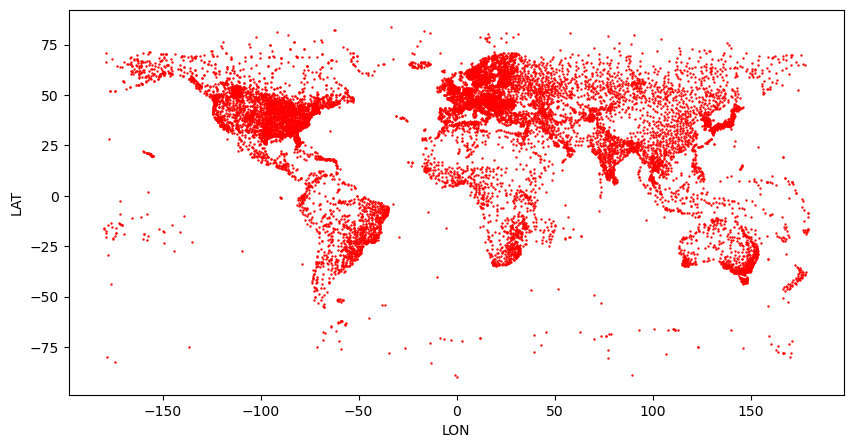

In [1]:
import pandas as pd
from haversine import haversine
import requests
import datetime
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 5]

def distanceToChicago(station):
    chicagoLatLong = (41.868, -87.665)
    return haversine((station['LAT'], station['LON']), chicagoLatLong)

def daysExpected(station):
    begin = datetime.datetime.strptime(station['BEGIN'], '%Y%m%d')
    end = datetime.datetime.strptime(station['END'], '%Y%m%d')
    return (end - begin).days

stations = pd.read_csv('https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv', dtype={'BEGIN': 'string', 'END': 'string'})
stations.dropna(subset=['LAT', 'LON'], inplace=True)
stations['distance_to_chicago'] = stations.apply(distanceToChicago, axis=1)
stations['days_expected'] = stations.apply(daysExpected, axis=1)
stations['begin_year'] = stations['BEGIN'].str.slice(0, 4)
stations['end_year'] = stations['END'].str.slice(0, 4)
stations.sort_values('distance_to_chicago', inplace=True)
# I'm really only interested in stations with current data
stations = stations[stations['end_year'].str.contains('2023')]
print(stations.head(10))

stations.plot(x='LON', y='LAT', kind='scatter', s=0.5, c='red')

Visually inspecting this, I see the two stations with the highest date coverage and the closest distance to Chicago are "CHICAGO MIDWAY INTL ARPT" and "CHICAGO O'HARE INTERNATIONAL AIRPORT".

Later we'll need to confirm quality and coverage of data with the actual data files.

In [2]:
chicagoStations = stations[stations['STATION NAME'].isin(['CHICAGO MIDWAY INTL ARPT', 'CHICAGO O\'HARE INTERNATIONAL AIRPORT'])]
print(chicagoStations)

         USAF   WBAN                          STATION NAME CTRY STATE  ICAO  \
20060  725340  14819              CHICAGO MIDWAY INTL ARPT   US    IL  KMDW   
20027  725300  94846  CHICAGO O'HARE INTERNATIONAL AIRPORT   US    IL  KORD   

          LAT     LON  ELEV(M)     BEGIN       END  distance_to_chicago  \
20060  41.784 -87.755    185.8  19730101  20231123             11.95220   
20027  41.960 -87.932    204.8  19461001  20231123             24.34657   

       days_expected begin_year end_year  
20060          18588       1973     2023  
20027          28177       1946     2023  


In [3]:
def checkUrlExists(url):
    try:
        # By only sending an HTTP HEAD request, we don't consume bandwidth 
        # by actually requesting the whole resource. We just check that it responds.
        response = requests.head(url)
        return response.status_code  == requests.codes.ok
    except requests.ConnectionError:
        print(f"Failed to connect to {url}.")
        return False

def gsodUrl(station, year):
    usaf, wban = station['USAF'], station['WBAN']
    return f"https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/{year}/{usaf}{wban}.csv"

def checkAllDataExists(station):
    allExists = True
    for year in range(int(station['begin_year']), int(station['end_year']) + 1):
        requestUrl = gsodUrl(station, year)
        if checkUrlExists(requestUrl):
            print(f"Data exists for year {year} at {requestUrl}")
        else:
            print(f"WARNING: Missing data for year {year} at {requestUrl}")
            allExists = False
    return allExists

# Let's check each of the Chicago stations to make sure we have all the data we expect:
for station in chicagoStations.iloc:
    name = station['STATION NAME']
    print(f"Checking that data exists for {name}")
    checkAllDataExists(station)

Checking that data exists for CHICAGO MIDWAY INTL ARPT
Data exists for year 1973 at https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1973/72534014819.csv
Data exists for year 1974 at https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1974/72534014819.csv
Data exists for year 1975 at https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1975/72534014819.csv
Data exists for year 1976 at https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1976/72534014819.csv
Data exists for year 1977 at https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1977/72534014819.csv
Data exists for year 1978 at https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1978/72534014819.csv
Data exists for year 1979 at https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1979/72534014819.csv
Data exists for year 1980 at https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/1980/72534014819.csv
Data exists for year 1981 at http

Oh no! There are missing data files for years 1970, 1971, and 1972 for the "CHICAGO O'HARE INTERNATIONAL AIRPORT" station. This won't do. Interestingly, this data is available when going through [this page](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094846/detail), but the files apparently aren't present in this GSOD CSV format. 

I'll just use the "CHICAGO MIDWAY INTL ARPT" station then and satisfy myself with data from 1973 to present day. Based on the BEGIN/END dates in the original station index file, I'm expecting to see 18587 days of data whereas the actual data we get back from GSOD has 18546 days worth of measurements, leaving a discreprancy of 41 days. The cause of this discrepancy may be in how the Python `timedelta` object calculates difference of two dates ([https://docs.python.org/3/library/datetime.html#timedelta-objects](https://docs.python.org/3/library/datetime.html#timedelta-objects)).  

In [4]:
def getAllData(station):
    beginYear, endYear = station['begin_year'], station['end_year']
    name = station['STATION NAME']
    data = []
    print(f"Downloading data for {name} from {beginYear} to {endYear}")
    for year in range(int(beginYear), int(endYear) + 1):
        requestUrl = gsodUrl(station, year)
        print(f"Downloading data for year {year} ({requestUrl})")
        data.append(pd.read_csv(gsodUrl(station, year)))
    return pd.concat(data)
    
station = stations[stations['STATION NAME'] == 'CHICAGO MIDWAY INTL ARPT'].iloc[0]
gsod = getAllData(station)

In [5]:
print(gsod)
print(gsod.dtypes)
print(gsod.describe())

         STATION        DATE  LATITUDE  LONGITUDE  ELEVATION  \
0    72534014819  1973-01-01  41.78611  -87.75222      186.5   
1    72534014819  1973-01-02  41.78611  -87.75222      186.5   
2    72534014819  1973-01-03  41.78611  -87.75222      186.5   
3    72534014819  1973-01-04  41.78611  -87.75222      186.5   
4    72534014819  1973-01-05  41.78611  -87.75222      186.5   
..           ...         ...       ...        ...        ...   
321  72534014819  2023-11-18  41.78412  -87.75514      185.8   
322  72534014819  2023-11-19  41.78412  -87.75514      185.8   
323  72534014819  2023-11-20  41.78412  -87.75514      185.8   
324  72534014819  2023-11-21  41.78412  -87.75514      185.8   
325  72534014819  2023-11-22  41.78412  -87.75514      185.8   

                              NAME  TEMP  TEMP_ATTRIBUTES  DEWP  \
0    CHICAGO MIDWAY AIRPORT, IL US  25.2               24  15.5   
1    CHICAGO MIDWAY AIRPORT, IL US  22.0               24  12.5   
2    CHICAGO MIDWAY AIRPORT, I

We have some erroneous values for `MIN` and `MAX`. According to the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt) these columns each have values to indicate missing data:

| Column | Missing Value Indicator |
| ------ | ----------------------- |
| MIN    | 9999.9                  |
| MAX    | 9999.9                  |

I'm not interested in data that doesn't have these measurements, so let's filter out these rows.

In [6]:
gsod = gsod[(gsod['MIN'] < 9999.9) & 
            (gsod['MAX'] < 9999.9)]
print(gsod)

         STATION        DATE  LATITUDE  LONGITUDE  ELEVATION  \
0    72534014819  1973-01-01  41.78611  -87.75222      186.5   
1    72534014819  1973-01-02  41.78611  -87.75222      186.5   
2    72534014819  1973-01-03  41.78611  -87.75222      186.5   
3    72534014819  1973-01-04  41.78611  -87.75222      186.5   
4    72534014819  1973-01-05  41.78611  -87.75222      186.5   
..           ...         ...       ...        ...        ...   
321  72534014819  2023-11-18  41.78412  -87.75514      185.8   
322  72534014819  2023-11-19  41.78412  -87.75514      185.8   
323  72534014819  2023-11-20  41.78412  -87.75514      185.8   
324  72534014819  2023-11-21  41.78412  -87.75514      185.8   
325  72534014819  2023-11-22  41.78412  -87.75514      185.8   

                              NAME  TEMP  TEMP_ATTRIBUTES  DEWP  \
0    CHICAGO MIDWAY AIRPORT, IL US  25.2               24  15.5   
1    CHICAGO MIDWAY AIRPORT, IL US  22.0               24  12.5   
2    CHICAGO MIDWAY AIRPORT, I

Since the `DATE` column appears to be a string in the format "YYYY-MM-DD", I'll break that down into separate columns for ease in filtering.

In [7]:
gsod['year'] = gsod.apply(lambda day: int(day['DATE'][:4]), axis=1)
gsod['month'] = gsod.apply(lambda day: int(day['DATE'][5:7]), axis=1)
gsod['day_of_month'] = gsod.apply(lambda day: int(day['DATE'][8:10]), axis=1)
gsod['day_of_year'] = gsod.apply(lambda day: int(datetime.datetime.strptime(day['DATE'], '%Y-%m-%d').strftime('%j')), axis=1)
print(gsod)

         STATION        DATE  LATITUDE  LONGITUDE  ELEVATION  \
0    72534014819  1973-01-01  41.78611  -87.75222      186.5   
1    72534014819  1973-01-02  41.78611  -87.75222      186.5   
2    72534014819  1973-01-03  41.78611  -87.75222      186.5   
3    72534014819  1973-01-04  41.78611  -87.75222      186.5   
4    72534014819  1973-01-05  41.78611  -87.75222      186.5   
..           ...         ...       ...        ...        ...   
321  72534014819  2023-11-18  41.78412  -87.75514      185.8   
322  72534014819  2023-11-19  41.78412  -87.75514      185.8   
323  72534014819  2023-11-20  41.78412  -87.75514      185.8   
324  72534014819  2023-11-21  41.78412  -87.75514      185.8   
325  72534014819  2023-11-22  41.78412  -87.75514      185.8   

                              NAME  TEMP  TEMP_ATTRIBUTES  DEWP  \
0    CHICAGO MIDWAY AIRPORT, IL US  25.2               24  15.5   
1    CHICAGO MIDWAY AIRPORT, IL US  22.0               24  12.5   
2    CHICAGO MIDWAY AIRPORT, I

<Axes: xlabel='day_of_year', ylabel='year'>

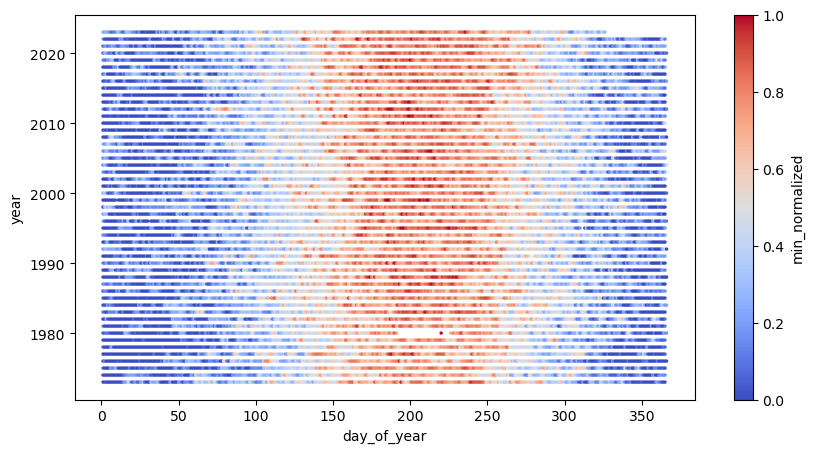

In [8]:
# Let's make 20 degrees Fahrenheit and colder the blue end of the color scale and 
# 80 degrees Fahrenheit and warmer the red end of the color scale.
def normalizeMinTemp(day):
    normalized = (day['MIN'] - 20.0) / (80.0 - 20.0)
    if normalized < 0.0:
        normalized = 0.0
    if normalized > 1.0:
        normalized = 1.0
    return normalized
gsod['min_normalized'] = gsod.apply(normalizeMinTemp, axis=1)
gsod.plot(x="day_of_year", y="year", kind="scatter", s=2, c="min_normalized", colormap="coolwarm")

Now that I've selected the station and downloaded all historical GSOD data, I'll export to CSV for manual import into Google BigQuery for further querying and analysis in Tableau Public.

In [9]:
gsod.to_csv(f"./GSOD - {station['STATION NAME']} - {station['USAF']}{station['WBAN']}.csv", index=False)